# Árbol de Decisión

En el presente notebook haremos un ejemplo de clasificación usando árboles de decisión en Python. El ejemplo se llevará a cabo con los datos [Wine](https://archive.ics.uci.edu/ml/datasets/wine) que están guardados en la librería scikit learn del propio Python.

Comenzamos cargando las librerías necesarias:

In [22]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine

Cargamos los datos y les damos el formato correcto:

In [23]:
# Carga de datos
data = load_wine()
# Los datos están en el siguiente formato: las variables explicativas son feature_names y la dependiente es target
# Lo pasamos a dataframe
df = pd.DataFrame(data.data, columns = data.feature_names)
# Creamos la columna del target que llamaremos Class
df['Class'] = data.target
print(np.unique(data.target))

[0 1 2]


Actualmente las clases se llaman 0, 1, 2, por claridad le cambiamos el nombre a class_0, class_1, class_2

In [24]:
target = np.unique(data.target)
target_names = np.unique(data.target_names)
targets = dict(zip(target, target_names))
df['Class'] = df['Class'].replace(targets)
print(np.unique(df['Class']))

['class_0' 'class_1' 'class_2']


## Análisis exploratorio

Hacemos un breve análisis exploratorio para conocer mejor nuestros datos

In [25]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,Class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,class_0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,class_0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,class_0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,class_0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,class_0


Estudiamos la distribución de las clases y vemos que están bastante balanceadas

In [26]:
df['Class'].value_counts()

class_1    71
class_0    59
class_2    48
Name: Class, dtype: int64

In [27]:
df.groupby('Class')['Class'].count()/df.shape[0]

Class
class_0    0.331461
class_1    0.398876
class_2    0.269663
Name: Class, dtype: float64

Analizamos ahora las variables explicativas. En este caso son todas continuas, pero un árbol de decisión admite tanto variables continuas como categóricas.

In [28]:
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Vemos que no sale el target en la tabla anterior. Para que nos salgan las variables categóricas debemos usar el código *df.describe(include = 'all')*.

## Modelo de clasificación

Separamos los datos en variables explicativas (X) y el target (y).

In [29]:
X = df.drop(columns="Class")
y = df["Class"]
# Guardamos los nombres para usarlos posteriormente en los gráficos
feature_names = X.columns
labels = y.unique()

Dividimos los datos en train y test, dedicaremos el 30% de los datos a test.

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

## Árbol de Decisión en Python: DecisionTreeClassifier

Ayuda y explicación de Python:
- [Understanding the decision tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html)
- [sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


Algunos de los parámetros a seleccionar en la función *DecisionTreeClassifier* de Python son:
- *criterion{“gini”, “entropy”}*. Criterio para medir la calidad de cada corte.
- *max_depth*. Máxima profundidad del árbol.
- *min_samples_split*. Número mínimo de muestras en un nodo intermedio para que se divida.
- *min_samples_leaf*. Número mínimo de muestras que tiene que haber en una nodo hoja.
- *min_impurity_decrease*. Reducción de impureza mínima que se admite para que un nodo se divida.
- *class_weight*. Para dar pesos diferentes a cada clase y que se penalice más el fallo en las clases deseadas. Se usa normalmente en los casos de datos desbalanceados.





Cargamos la librería e indicamos los parámetros del modelo:

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 5,random_state = 0)

Ajustamos el modelo a los datos de train

In [32]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=0)

Visualizamos el árbol creado:

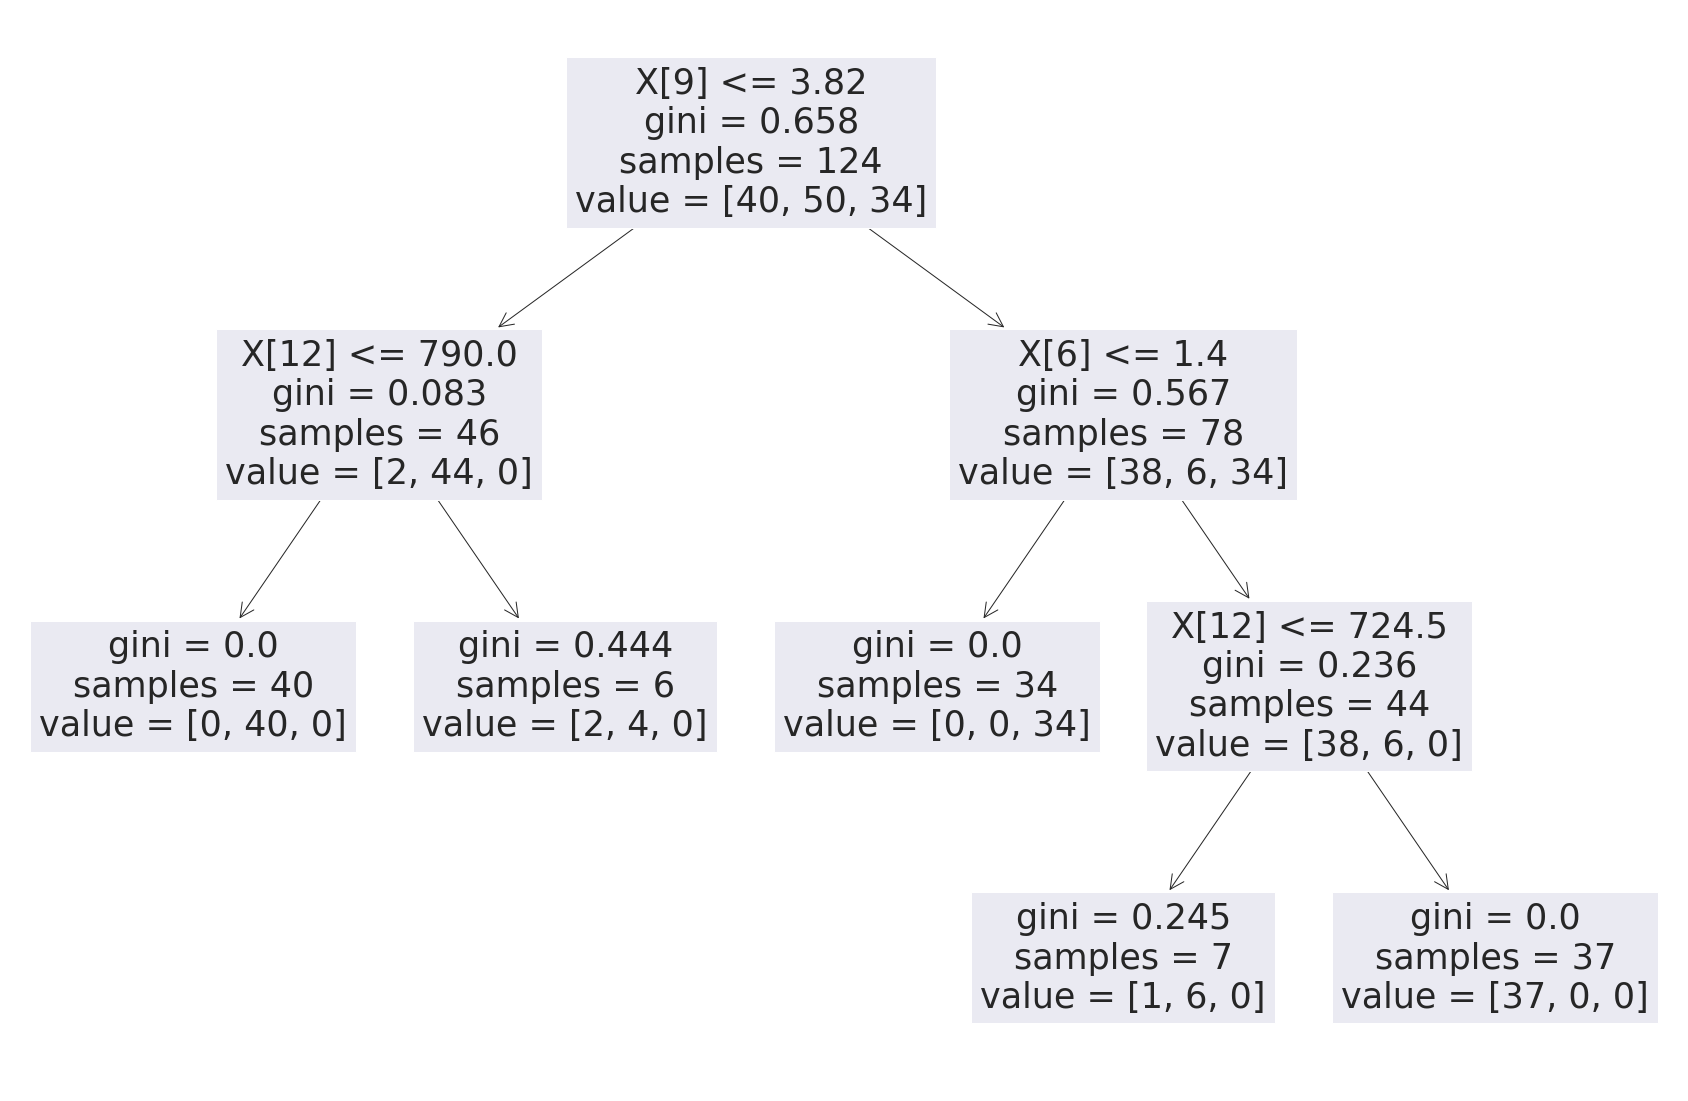

In [33]:
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(30,20), facecolor ='white')
tree.plot_tree(clf)
plt.show()

¡Añadamos información para que sea más claro y explicativo!

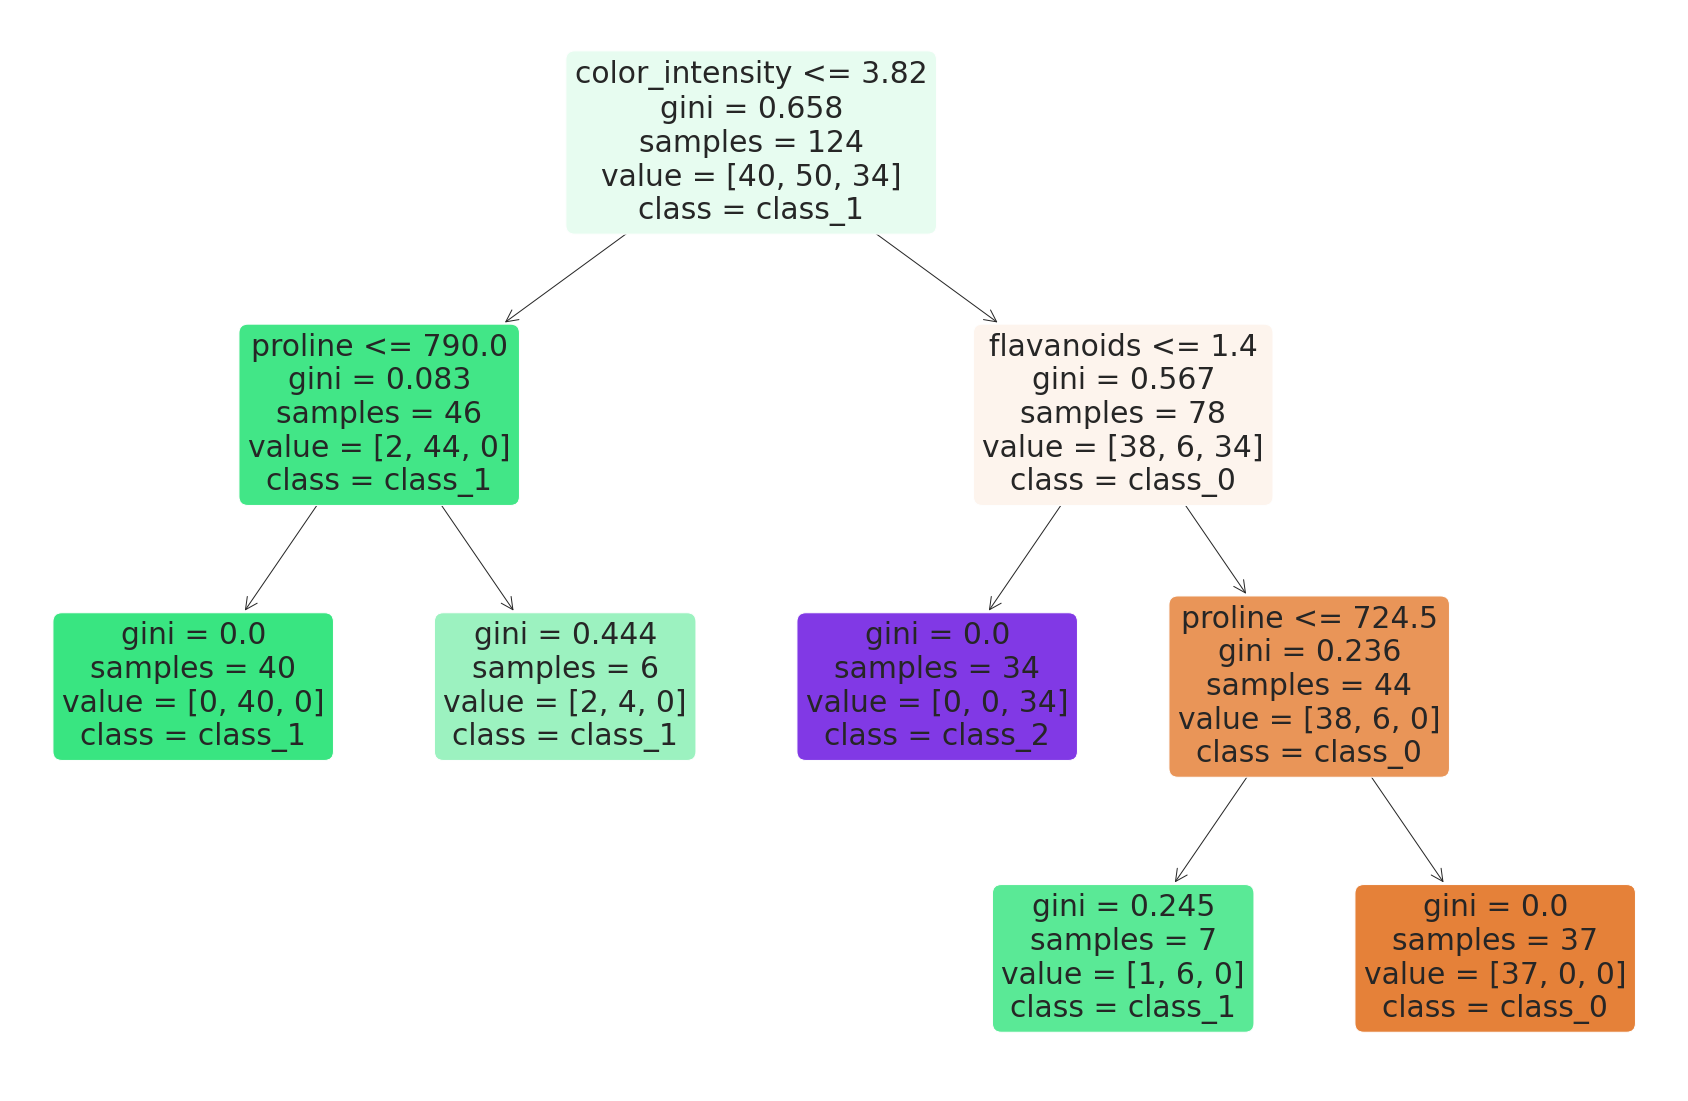

In [34]:
plt.figure(figsize=(30,20), facecolor ='white')
tree.plot_tree(clf,
               feature_names = feature_names,
               class_names=labels,
               rounded=True,
               filled = True);

También se puede visualizar mediante un diagrama de texto:

In [35]:
from sklearn.tree import export_text
tree_rules = export_text(clf,feature_names = list(feature_names))
print(tree_rules)

|--- color_intensity <= 3.82
|   |--- proline <= 790.00
|   |   |--- class: class_1
|   |--- proline >  790.00
|   |   |--- class: class_1
|--- color_intensity >  3.82
|   |--- flavanoids <= 1.40
|   |   |--- class: class_2
|   |--- flavanoids >  1.40
|   |   |--- proline <= 724.50
|   |   |   |--- class: class_1
|   |   |--- proline >  724.50
|   |   |   |--- class: class_0



## Predicción

In [36]:
y_pred = clf.predict(X_test)
print(y_pred)

['class_0' 'class_0' 'class_2' 'class_0' 'class_1' 'class_0' 'class_1'
 'class_2' 'class_1' 'class_2' 'class_1' 'class_1' 'class_0' 'class_1'
 'class_0' 'class_1' 'class_1' 'class_1' 'class_0' 'class_1' 'class_0'
 'class_1' 'class_1' 'class_2' 'class_2' 'class_2' 'class_1' 'class_1'
 'class_1' 'class_0' 'class_0' 'class_1' 'class_2' 'class_0' 'class_0'
 'class_0' 'class_2' 'class_2' 'class_1' 'class_2' 'class_1' 'class_1'
 'class_1' 'class_1' 'class_2' 'class_0' 'class_1' 'class_1' 'class_2'
 'class_0' 'class_1' 'class_0' 'class_0' 'class_2']


## Rendimiento

In [37]:
from sklearn import metrics
import seaborn as sns

In [38]:
confusion_matrix = metrics.confusion_matrix(y_pred,y_test)
print(confusion_matrix)

[[17  0  0]
 [ 2 21  1]
 [ 0  0 13]]


Lo visualizamos mejor poniéndole etiquetas y mediante un gráfico:

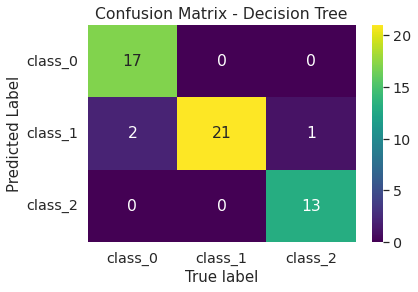

<Figure size 720x504 with 0 Axes>

In [39]:
matrix_df = pd.DataFrame(confusion_matrix)
ax = plt.axes()
sns.set(font_scale=1.3)
plt.figure(figsize=(10,7))
sns.heatmap(matrix_df, annot=True, fmt="g", ax=ax, cmap="viridis")
ax.set_title('Confusion Matrix - Decision Tree')
ax.set_xlabel("True label", fontsize =15)
ax.set_xticklabels(['']+labels)
ax.set_ylabel("Predicted Label", fontsize=15)
ax.set_yticklabels(list(labels), rotation = 0)
plt.show()

Accuracy:

In [40]:
metrics.accuracy_score(y_pred,y_test)

0.9444444444444444

Mediante el comando *classificacion_report* podemos obtener más información como la recall por clase:

In [41]:
from sklearn.metrics import classification_report

In [42]:
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class_0     1.0000    0.8947    0.9444        19
     class_1     0.8750    1.0000    0.9333        21
     class_2     1.0000    0.9286    0.9630        14

    accuracy                         0.9444        54
   macro avg     0.9583    0.9411    0.9469        54
weighted avg     0.9514    0.9444    0.9449        54



## Importancia de las variables

Podemos obtener la importancia de cada variable en el árbol final. Esta importancia se obtiene a partir del descenso del índice de Gini o de la entropía debido a los cortes que se han realizado en el árbol.


In [43]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance' : np.round(clf.feature_importances_, 3)})
importance.sort_values('importance', ascending=False, inplace = True)
print(importance)

                         feature  importance
6                     flavanoids       0.438
9                color_intensity       0.435
12                       proline       0.127
0                        alcohol       0.000
1                     malic_acid       0.000
2                            ash       0.000
3              alcalinity_of_ash       0.000
4                      magnesium       0.000
5                  total_phenols       0.000
7           nonflavanoid_phenols       0.000
8                proanthocyanins       0.000
10                           hue       0.000
11  od280/od315_of_diluted_wines       0.000


*Flavanoids* y *color_intensity* son las más importantes puesto que son las que más reducen el índice de Gini. Exceptuando *proline*, el resto de variables tienen importancia 0. Esto es porque no han participado en el árbol. La importancia de las variables se utiliza más cuando se ejecutan varios árboles y se agregan los resultados (ya veremos el Random Forest). Este estudio permite resumir la información de distintos árboles y ver qué variables participan en ellos y cuánto aportan.

## Selección automática de parámetros

Para elegir los mejores parámetros de forma más automática utilizaremos el comando *GridSearchCV* que, dada una lista de parámetros, probará todas sus combinaciones y devolverá la mejor opción en base al scoring que seleccione el usuario. En este caso, seleccionaremos el accuracy.

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
params_to_be_tuned = [{'max_depth': [2, 3, 4, 5, 6, 7],
                     'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}]

clf_grid = GridSearchCV(
        DecisionTreeClassifier(criterion = 'gini',random_state = 0), params_to_be_tuned,
        scoring='accuracy')
clf_grid.fit(X_train, y_train)

print("Mejores parámetros:")
print(clf_grid.best_params_)
print()
print("Mean y std en los conjuntos de validación")
means = clf_grid.cv_results_["mean_test_score"]
stds = clf_grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf_grid.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std * 2:0.03f}) for {params}")

Mejores parámetros:
{'max_depth': 3, 'min_samples_leaf': 6}

Mean y std en los conjuntos de validación
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 2}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 3}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 4}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 5}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 6}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 7}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 8}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 9}
0.903 (+/-0.042) for {'max_depth': 2, 'min_samples_leaf': 10}
0.935 (+/-0.082) for {'max_depth': 3, 'min_samples_leaf': 2}
0.935 (+/-0.082) for {'max_depth': 3, 'min_samples_leaf': 3}
0.935 (+/-0.082) for {'max_depth': 3, 'min_samples_leaf': 4}
0.935 (+/-0.082) for {'max_depth': 3, 'min_samples_leaf': 5}
0.943 (+/-0.065) for {'max_depth': 3, 'min_samples_leaf': 6}
0.927 (+/-0.106) for {'max_depth': 3, 'min

Ahora hacemos la predicción con la mejor opción:

In [46]:
# Model
clf = clf_grid.best_estimator_.fit(X_train, y_train)

y_pred2 = clf.predict(X_test)


In [47]:
metrics.accuracy_score(y_pred2,y_test)

0.9444444444444444

En este caso ha salido lo mismo porque los datos son muy sencillos.

## Datos reales

Podemos probar también con datos reales como [Pima](https://rdrr.io/cran/dprep/man/diabetes.html) o [Wisconsin](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28original%29).

In [48]:
pima = pd.read_csv('pima.csv')

In [49]:
pima.head()

,Preg,Plas,Pres,Skin,Insu,Mass,Pedi,Age,class
0,14,175,62,30,0,33.6,0.212,38,tested_positive
1,4,146,78,0,0,38.5,0.520,67,tested_positive
2,15,136,70,32,110,37.1,0.153,43,tested_positive
3,3,107,62,13,48,22.9,0.678,23,tested_positive
4,3,169,74,19,125,29.9,0.268,31,tested_positive


In [50]:
y = pima['class'].to_numpy()
X = pima.iloc[:,0:-1].to_numpy() # de 0 hasta la penúltima porque es la y

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state = 42)

In [52]:
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 7, min_samples_leaf = 5,random_state = 0)

In [53]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=0)

In [54]:
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_pred,y_test)

0.7445887445887446

In [55]:
params_to_be_tuned = [{'max_depth': [2, 3, 4, 5, 6, 7],
                     'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}]

clf_grid = GridSearchCV(
        DecisionTreeClassifier(criterion = 'gini',random_state = 0), params_to_be_tuned,
        scoring='accuracy')
clf_grid.fit(X_train, y_train)

print("Mejores parámetros:")
print(clf_grid.best_params_)
print()
print("Mean y std en los conjuntos de validación")
means = clf_grid.cv_results_["mean_test_score"]
stds = clf_grid.cv_results_["std_test_score"]
for mean, std, params in zip(means, stds,
                             clf_grid.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std * 2:0.03f}) for {params}")

Mejores parámetros:
{'max_depth': 5, 'min_samples_leaf': 10}

Mean y std en los conjuntos de validación
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 2}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 3}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 4}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 5}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 6}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 7}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 8}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 9}
0.760 (+/-0.066) for {'max_depth': 2, 'min_samples_leaf': 10}
0.756 (+/-0.045) for {'max_depth': 3, 'min_samples_leaf': 2}
0.756 (+/-0.045) for {'max_depth': 3, 'min_samples_leaf': 3}
0.756 (+/-0.045) for {'max_depth': 3, 'min_samples_leaf': 4}
0.758 (+/-0.041) for {'max_depth': 3, 'min_samples_leaf': 5}
0.756 (+/-0.054) for {'max_depth': 3, 'min_samples_leaf': 6}
0.756 (+/-0.054) for {'max_depth': 3, 'mi

In [56]:
# Model
clf = clf_grid.best_estimator_.fit(X_train, y_train)

y_pred2 = clf.predict(X_test)
metrics.accuracy_score(y_pred2,y_test)

0.7575757575757576

### Una última nota

En el siguiente notebook podéis consultar el código del árbol de decisión hecho desde 0:
[Código Decision Tree](https://github.com/rrunix/ml_models/blob/main/dt.ipynb)

# Árbol de regresión

La función de python para realizar un árbol de regresión es *DecisionTreeRegressor* cuya documentación puede encontrarse [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html). La principal diferencia con el árbol de decisión es el criterio para medir la calidad de cada división, ahora se centra en la varianza de los valores del target en cada nodo.